# Lab-11-4 RNN timeseries

In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

In [3]:
seq_length = 7

In [4]:
xy = np.loadtxt("./csv/data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order
xy

array([[5.68002570e+02, 5.68002570e+02, 5.52922516e+02, 1.31000000e+04,
        5.58462551e+02],
       [5.61202549e+02, 5.66432590e+02, 5.58672539e+02, 4.12000000e+04,
        5.59992565e+02],
       [5.66892592e+02, 5.67002574e+02, 5.56932537e+02, 1.08000000e+04,
        5.56972503e+02],
       ...,
       [8.19929993e+02, 8.24400024e+02, 8.18979980e+02, 1.28170000e+06,
        8.24159973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02],
       [8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02]])

In [5]:
# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

## Preprocessing

In [6]:
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [7]:
# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

## Build Dataset

In [8]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [9]:
# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

 [0.10377083 0.10109767 0.10978741 0.17505602 0.10310868]] -> [0.10860071]
[[0.15645373 0.14978906 0.17218495 0.11460966 0.15943724]
 [0.15255511 0.15285149 0.17064562 0.11901049 0.15024848]
 [0.14700052 0.14216724 0.15675561 0.1883302  0.13778586]
 [0.10473696 0.11103324 0.11805696 0.17297661 0.10198209]
 [0.10822158 0.10300312 0.11791384 0.19801918 0.09842631]
 [0.10377083 0.10109767 0.10978741 0.17505602 0.10310868]
 [0.09117814 0.09755902 0.11999024 0.11006543 0.10860071]] -> [0.10669948]
[[0.15255511 0.15285149 0.17064562 0.11901049 0.15024848]
 [0.14700052 0.14216724 0.15675561 0.1883302  0.13778586]
 [0.10473696 0.11103324 0.11805696 0.17297661 0.10198209]
 [0.10822158 0.10300312 0.11791384 0.19801918 0.09842631]
 [0.10377083 0.10109767 0.10978741 0.17505602 0.10310868]
 [0.09117814 0.09755902 0.11999024 0.11006543 0.10860071]
 [0.08572694 0.09960051 0.112544   0.11406292 0.10669948]] -> [0.11430396]
[[0.14700052 0.14216724 0.15675561 0.1883302  0.13778586]
 [0.10473696 0.111033

 [0.29278837 0.29283811 0.32269515 0.13980879 0.28905096]] -> [0.35852117]
[[0.3641268  0.39746527 0.41181116 0.28764979 0.40296262]
 [0.38085265 0.3826114  0.40817603 0.12441529 0.39358476]
 [0.36868294 0.35791349 0.36885848 0.14085242 0.37118466]
 [0.34931971 0.33710577 0.34698853 0.11932761 0.3230394 ]
 [0.32318191 0.31010892 0.31094226 0.18250433 0.28845341]
 [0.29278837 0.29283811 0.32269515 0.13980879 0.28905096]
 [0.3174871  0.33168294 0.34710981 0.18593339 0.35852117]] -> [0.3603131]
[[0.38085265 0.3826114  0.40817603 0.12441529 0.39358476]
 [0.36868294 0.35791349 0.36885848 0.14085242 0.37118466]
 [0.34931971 0.33710577 0.34698853 0.11932761 0.3230394 ]
 [0.32318191 0.31010892 0.31094226 0.18250433 0.28845341]
 [0.29278837 0.29283811 0.32269515 0.13980879 0.28905096]
 [0.3174871  0.33168294 0.34710981 0.18593339 0.35852117]
 [0.31095255 0.33740042 0.35774787 0.07508526 0.3603131 ]] -> [0.30553713]
[[0.36868294 0.35791349 0.36885848 0.14085242 0.37118466]
 [0.34931971 0.3371057

In [10]:
# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

## Hyperparameters

In [17]:
input_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
epochs = 500

## Model

In [15]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
    
    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [19]:
net = Net(input_dim, hidden_dim, output_dim, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [21]:
for epoch in range(epochs+1):
    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print('Epoch:', epoch, 'Loss:', loss.item())

Epoch: 0 Loss: 0.0013547223061323166
Epoch: 50 Loss: 0.0013332418166100979
Epoch: 100 Loss: 0.0013132448075339198
Epoch: 150 Loss: 0.001294605783186853
Epoch: 200 Loss: 0.0012772537302225828
Epoch: 250 Loss: 0.0012611510464921594
Epoch: 300 Loss: 0.0012462567538022995
Epoch: 350 Loss: 0.001232500304467976
Epoch: 400 Loss: 0.0012197836767882109
Epoch: 450 Loss: 0.0012079960433766246
Epoch: 500 Loss: 0.0011970370542258024


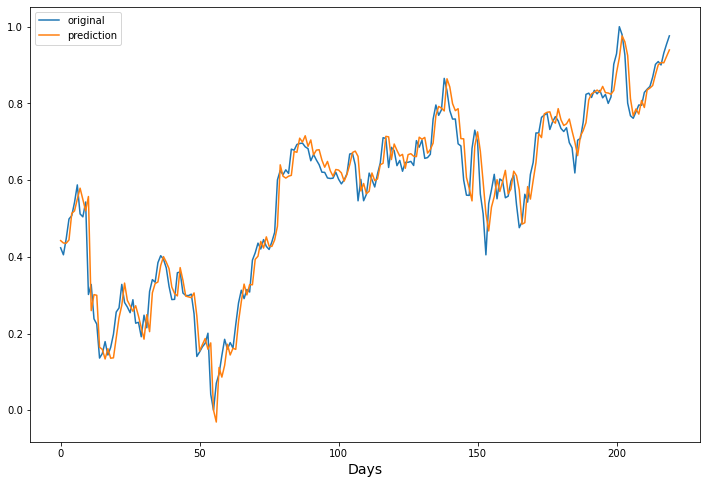

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.xlabel('Days', fontsize=14)
plt.show()